In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e3', 'e4', 'e5', 'e6']
#aedge='orange'

#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [11]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [12]:
d = cp.generate_decline(dfc, scale=False)

In [13]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [14]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = d.groupby(groupby_cols).apply(convert_func).reset_index() 

In [15]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds[ds.day < 80]

In [16]:
ds.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL
0,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,0,3.352
1,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,1,2.439
2,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,2,2.576
3,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,3,2.345
4,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,4,1.676


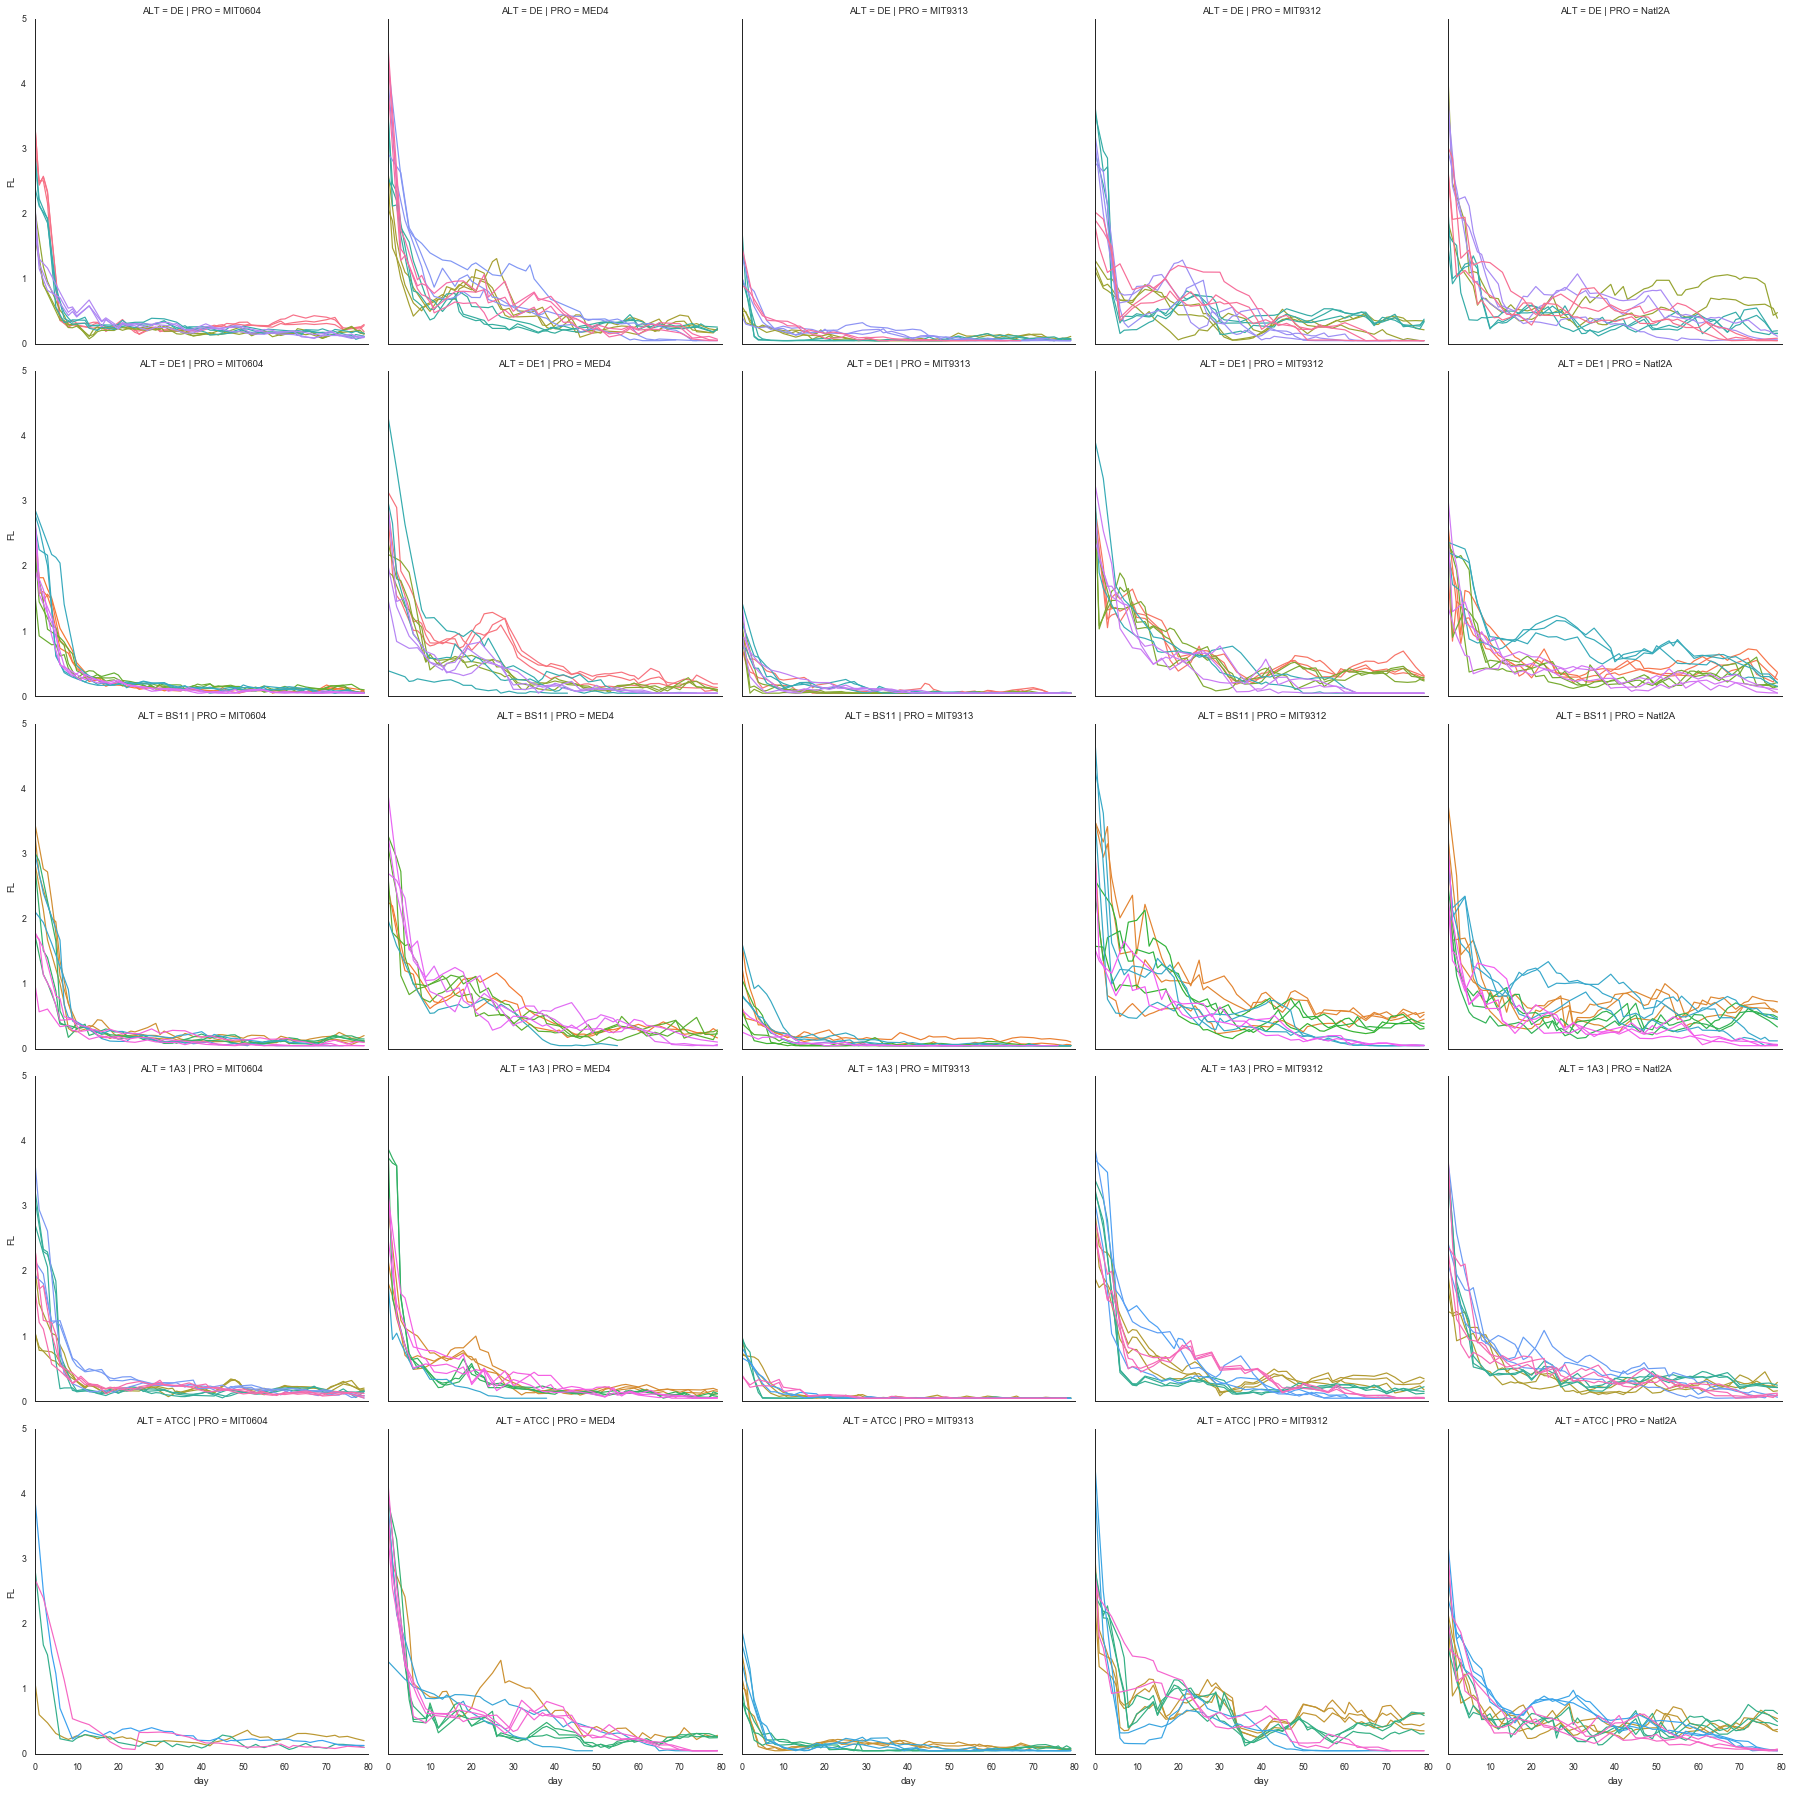

In [83]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            x='day', y='FL', kind='line', hue='experiment_sample', legend=False)

In [84]:
ds['decline'] = ds['FL']

In [85]:
train_df_orig, test_df_orig = cp.split_train_test(ds,test_size=0.4)

In [86]:
train_df = cp.augment_training(train_df_orig)
test_df = test_df_orig

In [87]:
train_df = train_df.loc[train_df.day < 80]

In [88]:
stats_list = []
y_list = []
clf_list = []
features_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train_df, test_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=10,
               return_y=True)
stats_list.extend(res)
y_list.extend(_y_list)
clf_list.extend(_clf_list)
features_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [89]:
stats_df = pd.DataFrame.from_records(stats_list)

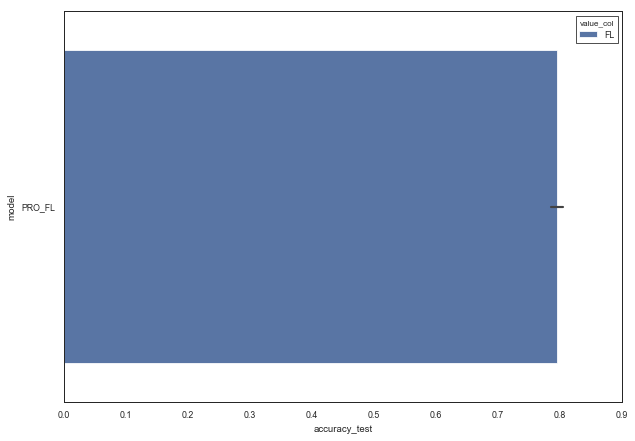

In [90]:
f, ax = plt.subplots(figsize=(10, 7))
v='accuracy_test'
sns.barplot(x=v, y="model", data=stats_df.sort_values(by=v).nlargest(columns=v, n=20),
            hue='value_col')

In [91]:
stats_df

,accuracy_test,accuracy_train,f1_test,f1_train,model,n_features,orig_n_features,precision_test,precision_train,recall_test,recall_train,support_test,support_train,value_col,y_col
0,0.824074,1.0,0.821870,1.0,PRO_FL,80,80,0.827617,1.0,0.824074,1.0,None,None,FL,PRO
1,0.768519,1.0,0.764937,1.0,PRO_FL,80,80,0.782661,1.0,0.768519,1.0,None,None,FL,PRO
2,0.814815,1.0,0.812233,1.0,PRO_FL,80,80,0.829693,1.0,0.814815,1.0,None,None,FL,PRO
3,0.787037,1.0,0.782241,1.0,PRO_FL,80,80,0.805028,1.0,0.787037,1.0,None,None,FL,PRO
4,0.777778,1.0,0.775381,1.0,PRO_FL,80,80,0.791423,1.0,0.777778,1.0,None,None,FL,PRO
5,0.796296,1.0,0.793935,1.0,PRO_FL,80,80,0.815086,1.0,0.796296,1.0,None,None,FL,PRO
6,0.787037,1.0,0.786229,1.0,PRO_FL,80,80,0.808351,1.0,0.787037,1.0,None,None,FL,PRO
7,0.787037,1.0,0.783782,1.0,PRO_FL,80,80,0.803098,1.0,0.787037,1.0,None,None,FL,PRO
8,0.796296,1.0,0.794295,1.0,PRO_FL,80,80,0.808514,1.0,0.796296,1.0,None,None,FL,PRO
9,0.805556,1.0,0.804271,1.0,PRO_FL,80,80,0.816051,1.0,0.805556,1.0,None,None,FL,PRO


In [92]:
stats_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
0,0.821870,0.824074,1.0
2,0.812233,0.814815,1.0
9,0.804271,0.805556,1.0
8,0.794295,0.796296,1.0
5,0.793935,0.796296,1.0
6,0.786229,0.787037,1.0
7,0.783782,0.787037,1.0
3,0.782241,0.787037,1.0
4,0.775381,0.777778,1.0
1,0.764937,0.768519,1.0


In [170]:
idx = 2
y_df =  _y_list[idx]
clf = _clf_list[idx]
features = _features_list[idx]

In [171]:
y_df.head()

,PRO_FL_y,PRO_FL_y_PRO,PRO_FL_y_pred,PRO_FL_y_pred_PRO,Type
experiment_sample,,,,,
"e3, 10A, FL_0.05_0_first",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_last",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_max",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_mean",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_median",MIT0604,MIT0604,MIT0604,MIT0604,Train


accuracy: 0.8148148148148148
              precision    recall  f1-score   support

        MED4       0.68      0.81      0.74        21
     MIT0604       0.74      0.95      0.83        21
     MIT9312       0.88      0.64      0.74        22
     MIT9313       0.95      1.00      0.98        20
      Natl2A       0.89      0.71      0.79        24

   micro avg       0.81      0.81      0.81       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.81      0.81       108



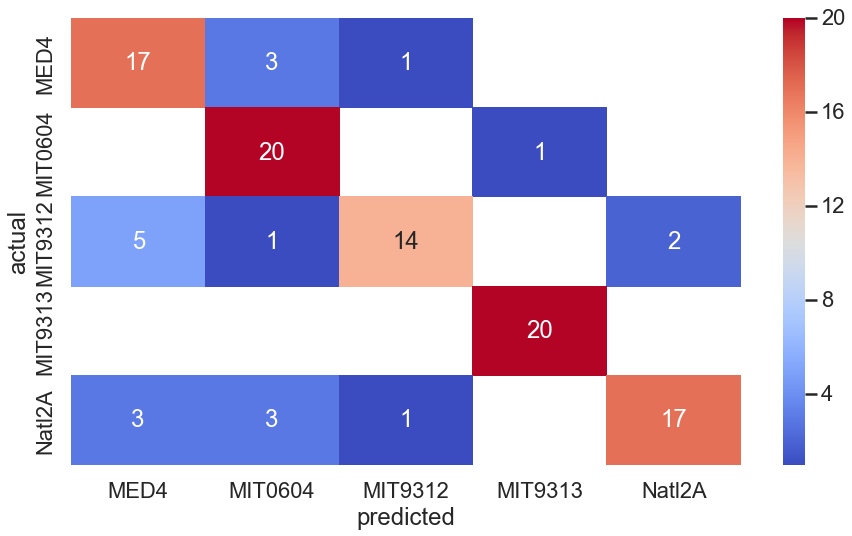

In [172]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


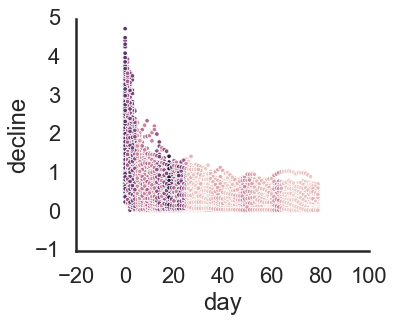

In [173]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = features,
                                    columns=['importance'])
mergedf = ds.merge(feature_importances, left_on='day', right_index=True, how='left')
mergedf.head()
sns.relplot(data=mergedf, x='day', y='decline', hue='importance', legend=None, aspect=1.2)

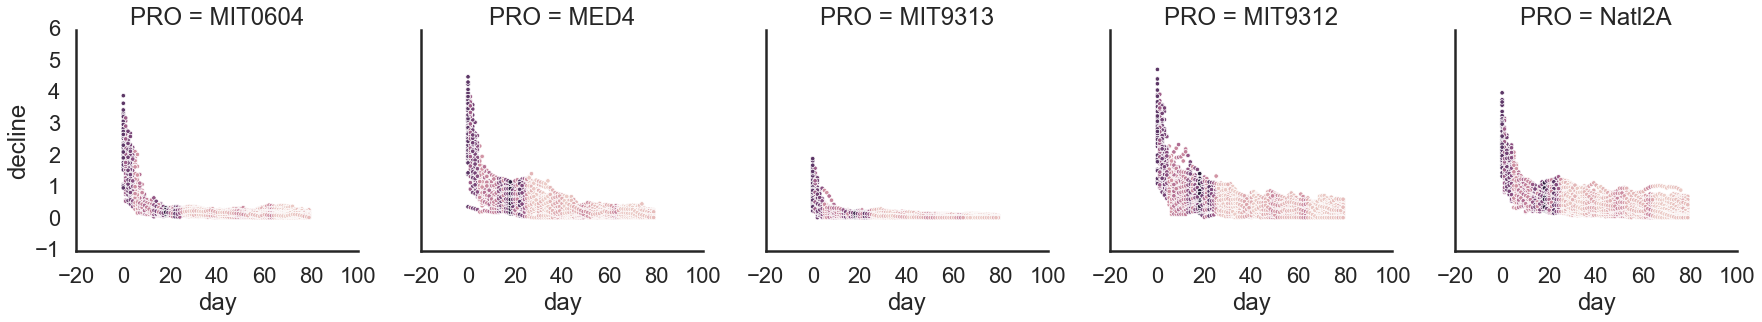

In [174]:
sns.relplot(data=mergedf, x='day', y='decline', hue='importance', legend=None, col='PRO')

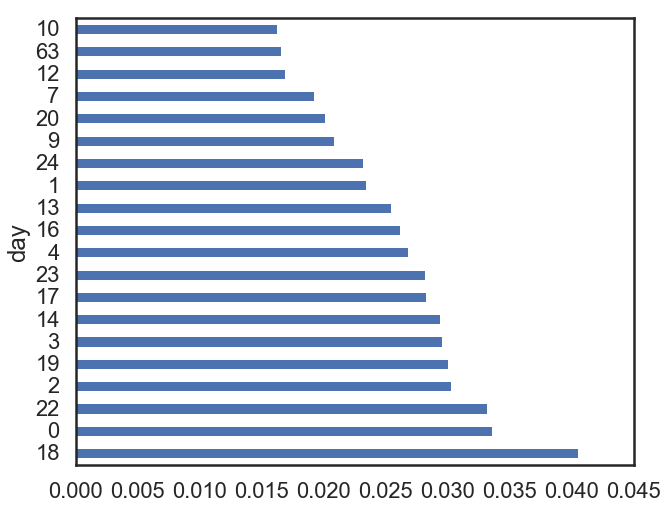

In [175]:
feature_importances.nlargest(columns='importance',n=20).plot(kind='barh', legend=False,  figsize=(10,8) )

# cluster by decline

In [99]:
value_col = 'decline'

In [24]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

NameError: name 'ds' is not defined

In [101]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

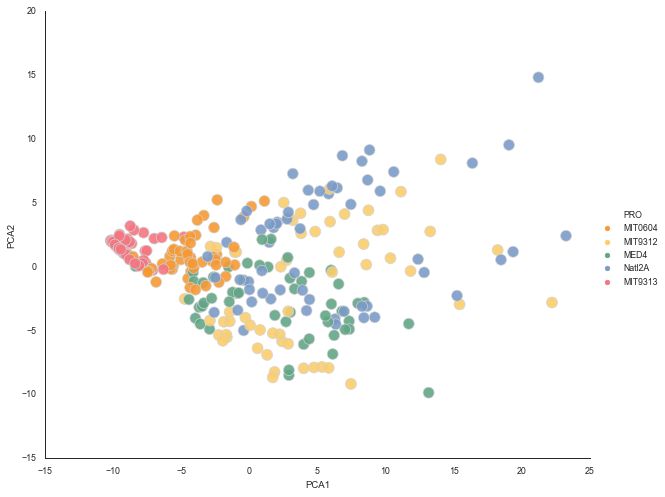

In [102]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

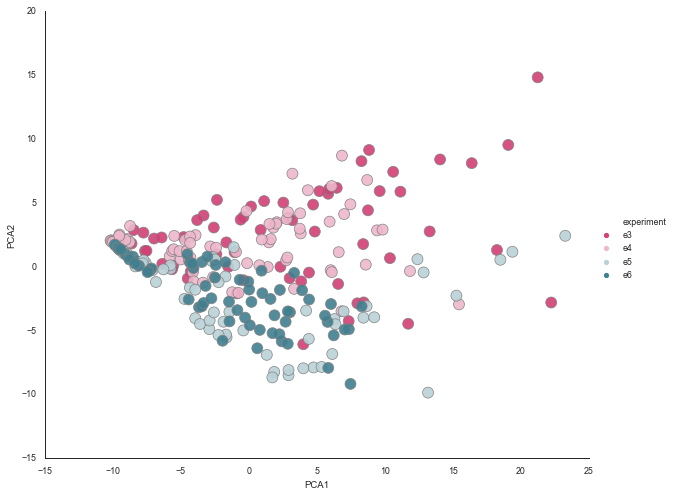

In [103]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

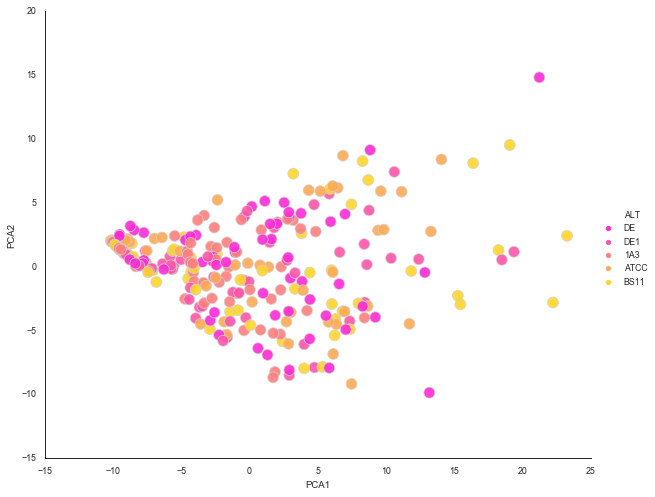

In [104]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

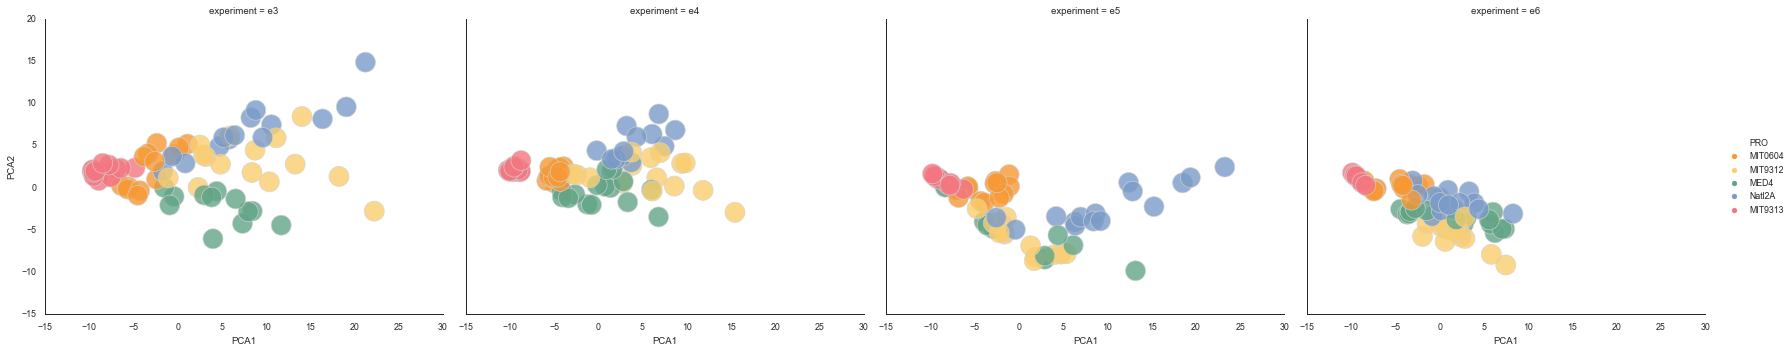

In [105]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

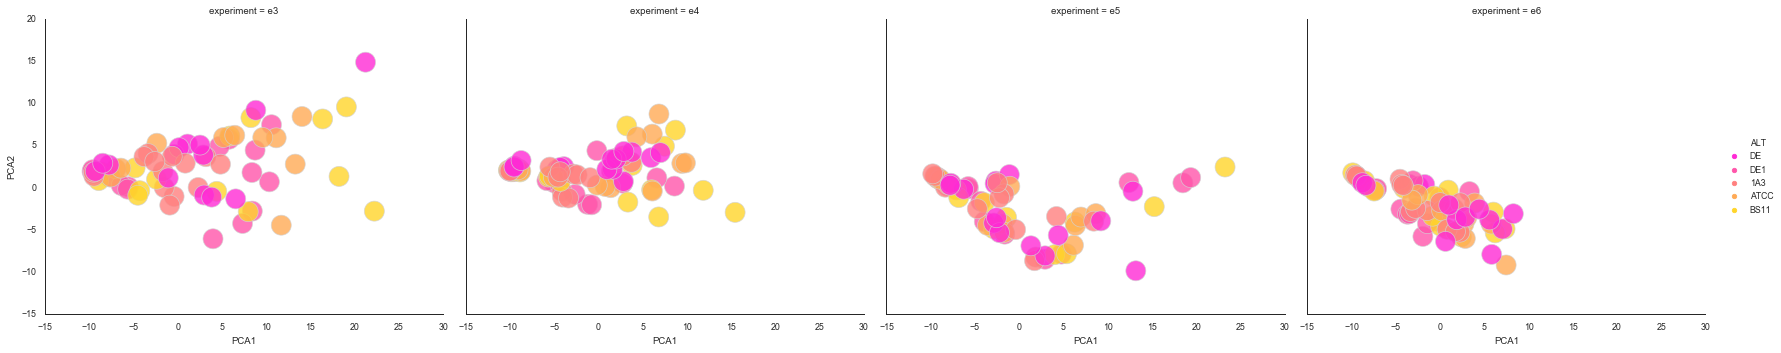

In [106]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

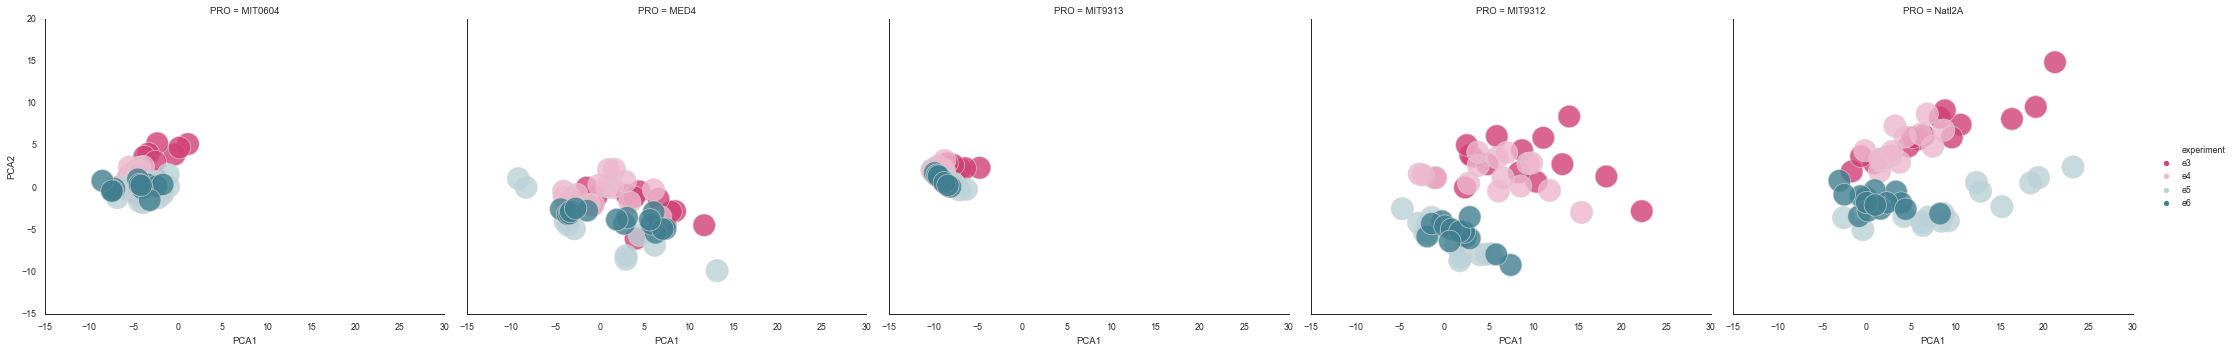

In [107]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=500, alpha=0.8, height=5, aspect=1.2,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [108]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


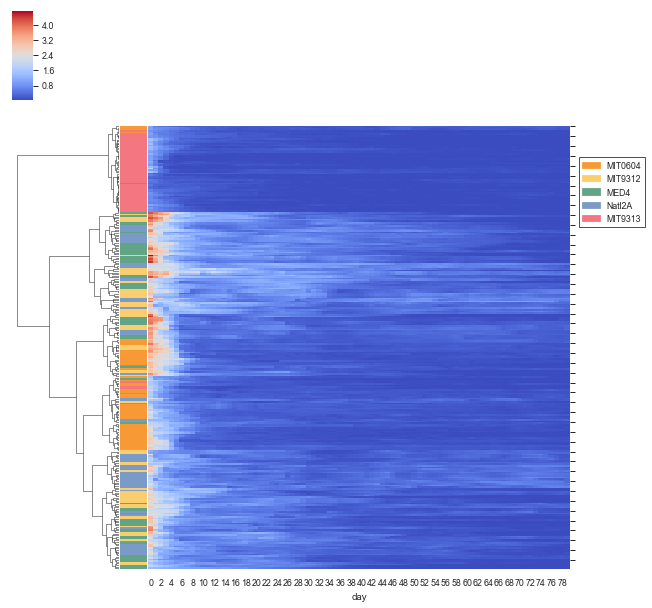

In [109]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

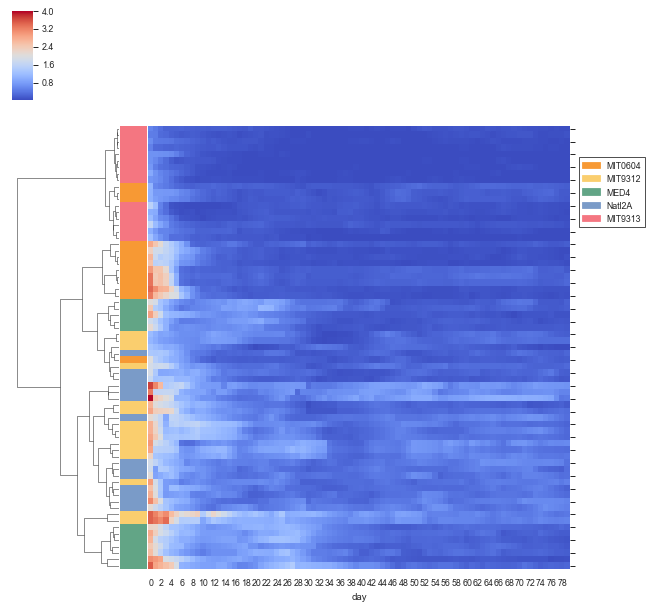

In [110]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

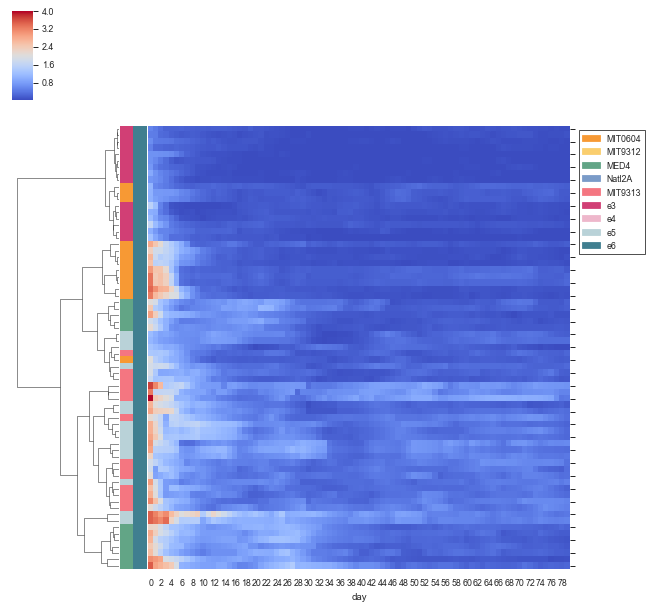

In [111]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

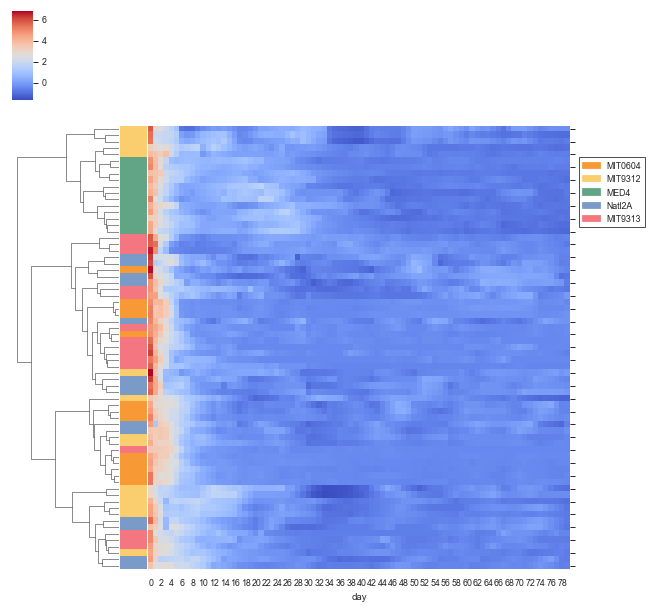

In [112]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [13]:
df_features = cp.generate_features(dfc)

In [20]:
dfc_norm = dfc.copy()
dfc_norm.FL = dfc_norm.groupby('experiment_sample').FL.transform(lambda x : x / max(x)) #.reset_index()
df_features_norm = cp.generate_features(dfc_norm)

In [14]:
X_features = cp.features2X(df_features)
metadf_features = cp.get_meta(df_features, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features.index = metadf_features.experiment_sample
y = metadf_features['PRO']

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [21]:
X_features_norm = cp.features2X(df_features_norm)
metadf_features_norm = cp.get_meta(df_features_norm, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features_norm.index = metadf_features_norm.experiment_sample
#y = metadf_features['PRO']

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [116]:
from sklearn.linear_model import LogisticRegression


In [126]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [131]:
import tsfresh
from tsfresh.utilities.dataframe_functions import impute


In [120]:
#ts_f_metadf = cp.get_meta(dfc)
#ts_f_metadf.index = ts_f_metadf.experiment_sample
#ts_f_y= ts_f_metadf.PRO 
ts_f_features_df = tsfresh.extract_features(
    dfc.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  1.64s/it]


In [123]:
#ts_f_metadf = cp.get_meta(dfc)
#ts_f_metadf.index = ts_f_metadf.experiment_sample
#ts_f_y= ts_f_metadf.PRO 
ts_d_features_df = tsfresh.extract_features(
    d.loc[:, ['experiment_sample', 'FL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  3.34it/s]


In [132]:
ts_d_features_df = impute(ts_d_features_df)
ts_f_features_df = impute(ts_f_features_df)

 'FL__fft_coefficient__coeff_38__attr_"angle"'
 'FL__fft_coefficient__coeff_38__attr_"imag"'
 'FL__fft_coefficient__coeff_38__attr_"real"'
 'FL__fft_coefficient__coeff_39__attr_"abs"'
 'FL__fft_coefficient__coeff_39__attr_"angle"'
 'FL__fft_coefficient__coeff_39__attr_"imag"'
 'FL__fft_coefficient__coeff_39__attr_"real"'
 'FL__fft_coefficient__coeff_40__attr_"abs"'
 'FL__fft_coefficient__coeff_40__attr_"angle"'
 'FL__fft_coefficient__coeff_40__attr_"imag"'
 'FL__fft_coefficient__coeff_40__attr_"real"'
 'FL__fft_coefficient__coeff_41__attr_"abs"'
 'FL__fft_coefficient__coeff_41__attr_"angle"'
 'FL__fft_coefficient__coeff_41__attr_"imag"'
 'FL__fft_coefficient__coeff_41__attr_"real"'
 'FL__fft_coefficient__coeff_42__attr_"abs"'
 'FL__fft_coefficient__coeff_42__attr_"angle"'
 'FL__fft_coefficient__coeff_42__attr_"imag"'
 'FL__fft_coefficient__coeff_42__attr_"real"'
 'FL__fft_coefficient__coeff_43__attr_"abs"'
 'FL__fft_coefficient__coeff_43__attr_"angle"'
 'FL__fft_coefficient__coeff_43__

 'FL__fft_coefficient__coeff_40__attr_"angle"'
 'FL__fft_coefficient__coeff_40__attr_"imag"' ...
 'ratelogFL__fft_coefficient__coeff_99__attr_"angle"'
 'ratelogFL__fft_coefficient__coeff_99__attr_"imag"'
 'ratelogFL__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


In [133]:
ts_f_features_df.head()

variable,FL__abs_energy,FL__absolute_sum_of_changes,"FL__agg_autocorrelation__f_agg_""mean""__maxlag_40","FL__agg_autocorrelation__f_agg_""median""__maxlag_40","FL__agg_autocorrelation__f_agg_""var""__maxlag_40","FL__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","FL__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","FL__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","FL__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","FL__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,ratelogFL__symmetry_looking__r_0.9,ratelogFL__symmetry_looking__r_0.9500000000000001,ratelogFL__time_reversal_asymmetry_statistic__lag_1,ratelogFL__time_reversal_asymmetry_statistic__lag_2,ratelogFL__time_reversal_asymmetry_statistic__lag_3,ratelogFL__value_count__value_-1,ratelogFL__value_count__value_0,ratelogFL__value_count__value_1,ratelogFL__variance,ratelogFL__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
"e3, 10A",42.901035,8.950,0.031062,-0.033334,0.048752,2.380167,-0.785511,-0.397512,0.127852,3.352,...,1.0,1.0,-0.000431,-0.000167,0.001684,0.0,3.0,0.0,0.034217,0.0
"e3, 10B",41.128762,9.036,0.029610,-0.025730,0.047685,2.352417,-0.780775,-0.399619,0.130555,3.345,...,1.0,1.0,0.001554,0.000914,-0.000426,0.0,4.0,0.0,0.045040,0.0
"e3, 10C",39.859399,8.078,0.030677,-0.025873,0.048860,2.194333,-0.782568,-0.365452,0.118691,2.999,...,1.0,1.0,-0.000578,0.000980,-0.002282,0.0,4.0,0.0,0.042542,0.0
"e3, 11A",54.532152,7.990,0.048207,0.052546,0.113174,1.731417,-0.672924,-0.244190,0.109585,2.852,...,1.0,1.0,-0.000300,0.000051,-0.000239,0.0,12.0,0.0,0.030753,0.0
"e3, 11B",56.052321,8.212,0.045080,0.083166,0.110557,1.898167,-0.711141,-0.291940,0.117828,3.135,...,1.0,1.0,-0.000724,-0.000034,0.001563,0.0,8.0,0.0,0.029374,0.0


In [134]:
ts_d_features_df.shape, ts_f_features_df.shape, X.shape

((270, 794), (270, 4764), (270, 67))

In [137]:
scores = {c : compute_corr(X_features[c], y) for c in X_features.columns }

In [138]:
scores.update({f'decline_{c}' : compute_corr(ts_d_features_df[c], y) for c in ts_d_features_df.columns })
scores.update({f'full_{c}' : compute_corr(ts_f_features_df[c], y) for c in ts_f_features_df.columns })


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

In [139]:
scores_df = pd.Series(scores)

In [141]:
scores_df.nlargest(20)

full_logFL__quantile__q_0.8                                                      0.588889
full_cumsumFL__standard_deviation                                                0.574074
full_cumsumFL__variance                                                          0.566667
decline_FL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_10              0.562963
full_logFL__range_count__max_1__min_-1                                           0.551852
decline_FL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_10              0.544444
full_cumsumlogFL__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2    0.540741
decline_FL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10              0.537037
decline_mean_log                                                                 0.533333
decline_FL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_20              0.533333
full_logFL__mean                                                                 0.533333
full_logFL

In [156]:
scores_df.nsmallest(20)

full_cumsumFL__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"    0.129630
full_cumsumFL__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"rvalue"     0.140741
full_FL__fft_coefficient__coeff_21__attr_"imag"                               0.148148
full_FL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5                0.151852
full_rateFL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_5            0.162963
full_rateFL__fft_coefficient__coeff_2__attr_"real"                            0.162963
full_FL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5                0.166667
full_rateFL__fft_coefficient__coeff_16__attr_"real"                           0.166667
full_rateFL__fft_coefficient__coeff_22__attr_"real"                           0.166667
full_ratelogFL__skewness                                                      0.170370
full_FL__fft_coefficient__coeff_5__attr_"real"                                0.174074
full_rateFL__cwt_coefficients__widths_(2, 5

In [17]:
#ts_f_features_df['PRO'] = metadf_features.PRO
#ts_d_features_df['PRO'] = metadf_features.PRO
X_features['PRO'] = metadf_features.PRO
X_features['experiement'] = metadf_features.experiment


C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [31]:
#ts_f_features_df['PRO'] = metadf_features.PRO
#ts_d_features_df['PRO'] = metadf_features.PRO
X_features_norm['PRO'] = metadf_features_norm.PRO
X_features_norm['experiement'] = metadf_features_norm.experiment
X_features_norm['relative_decline_auc'] =X_features_norm['decline_auc']



C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

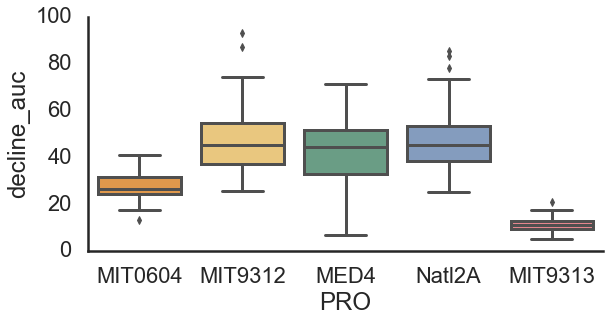

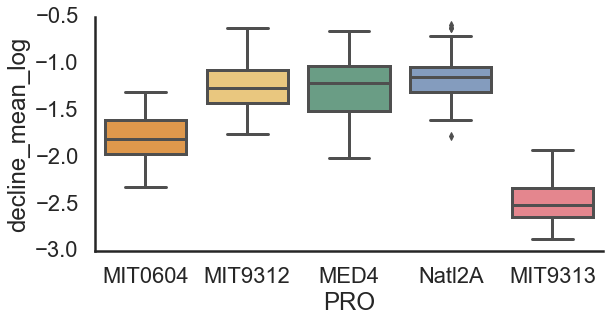

In [18]:
#c = 'logFL__quantile__q_0.8'
#for k in ["point", "bar", "strip", "swarm", "box", "violin", "boxen"]:
#sns.catplot(data=ts_f_features_df, y=c, x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)
sns.catplot(data=X_features, y='decline_auc', x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)
sns.catplot(data=X_features, y='decline_mean_log', x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)


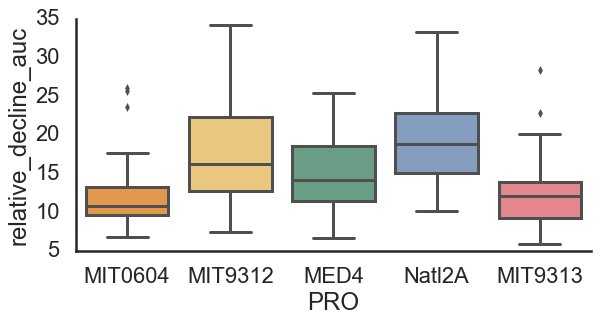

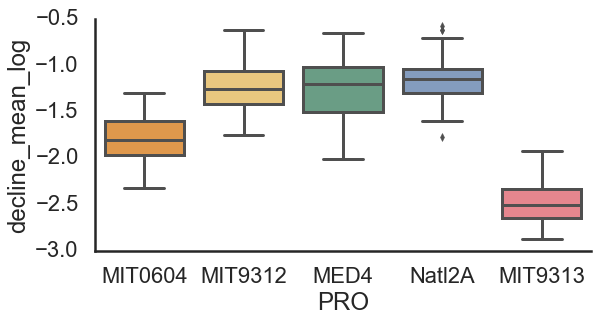

In [32]:
#c = 'logFL__quantile__q_0.8'
#for k in ["point", "bar", "strip", "swarm", "box", "violin", "boxen"]:
#sns.catplot(data=ts_f_features_df, y=c, x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)
sns.catplot(data=X_features_norm, y='relative_decline_auc', x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)
sns.catplot(data=X_features_norm, y='decline_mean_log', x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)


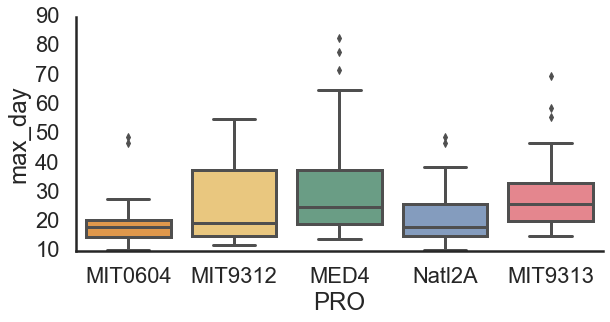

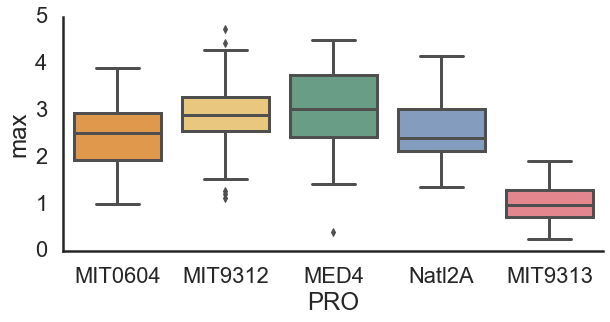

In [23]:
sns.catplot(data=X_features, y='max_day', x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)
sns.catplot(data=X_features, y='max', x='PRO', kind='box', order=porder, palette=ppallete, aspect=1.8)


In [181]:
X_features.max_day.nsmallest(10)

experiment_sample
e3, 24A    10.13
e3, 25C    10.13
e4, 10A    11.88
e4, 10B    11.88
e4, 10C    11.88
e4, 15C    11.88
e4, 18C    11.88
e4, 23A    11.88
e4, 23B    11.88
e4, 23C    11.88
Name: max_day, dtype: float64

In [182]:
X_features.max_day.nlargest(10)

experiment_sample
e5, 1C     82.79
e5, 11C    77.86
e5, 21B    71.78
e6, 17A    69.70
e5, 16B    65.08
e6, 7C     58.70
e6, 7A     55.58
e5, 11B    54.95
e5, 13B    54.95
e6, 8B     51.74
Name: max_day, dtype: float64

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


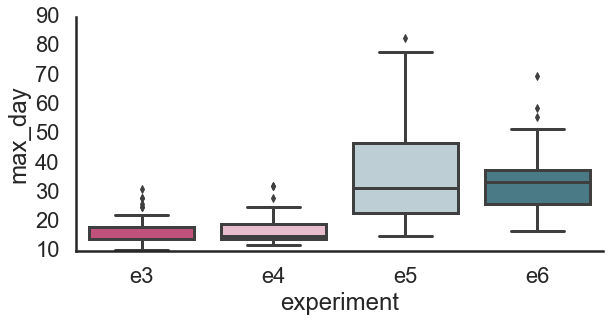

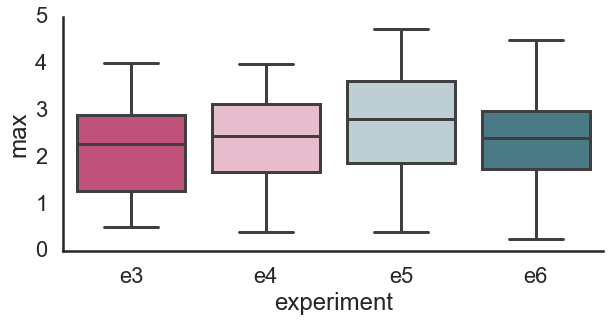

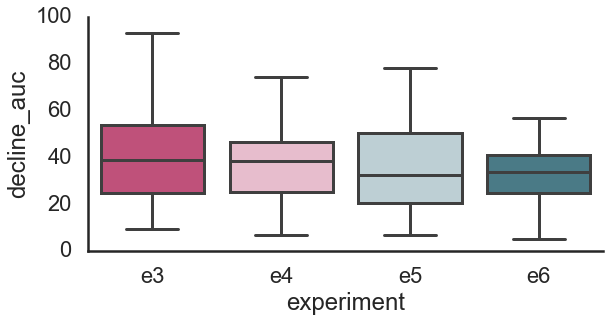

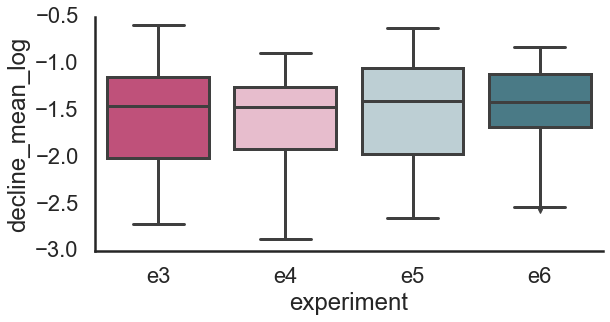

In [20]:
X_features['experiment'] = metadf_features.experiment
sns.catplot(data=X_features, y='max_day', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)
sns.catplot(data=X_features, y='max', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)
sns.catplot(data=X_features, y='decline_auc', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)
sns.catplot(data=X_features, y='decline_mean_log', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)


C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


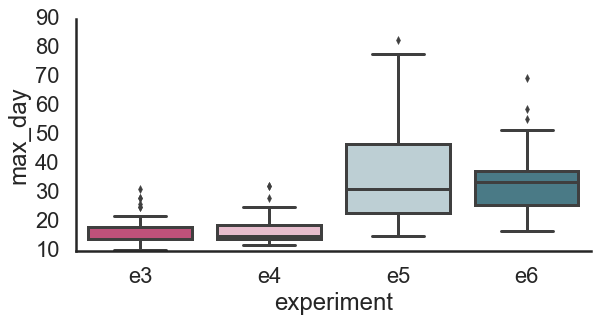

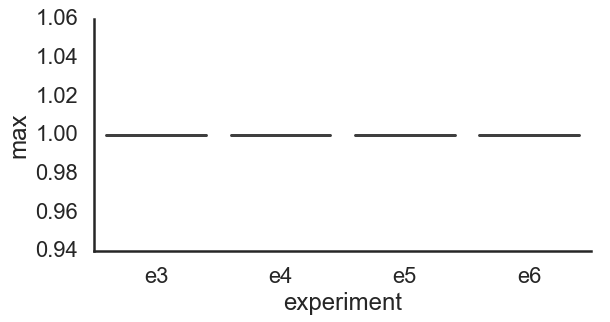

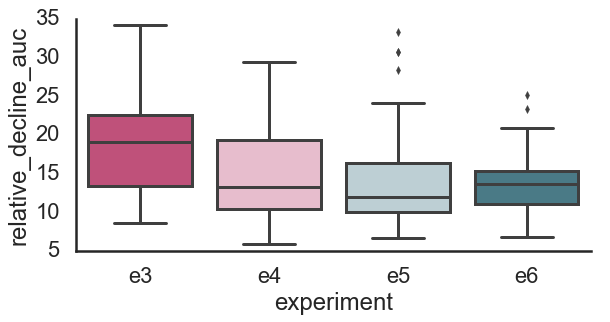

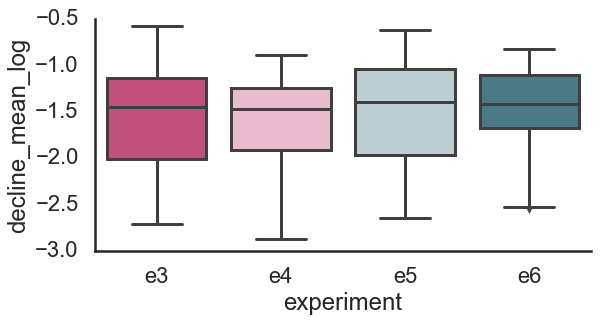

In [33]:
X_features_norm['experiment'] = metadf_features_norm.experiment
sns.catplot(data=X_features_norm, y='max_day', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)
sns.catplot(data=X_features_norm, y='max', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)
sns.catplot(data=X_features_norm, y='relative_decline_auc', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)
sns.catplot(data=X_features_norm, y='decline_mean_log', x='experiment', kind='box', order=eorder, palette=epallete, aspect=1.8)


In [34]:
X_features['experiment'] = metadf_features.experiment
sns.catplot(data=X_features, y='max_day', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features, y='max', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features, y='decline_auc', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features, y='decline_mean_log', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)


NameError: name 'metadf_features' is not defined

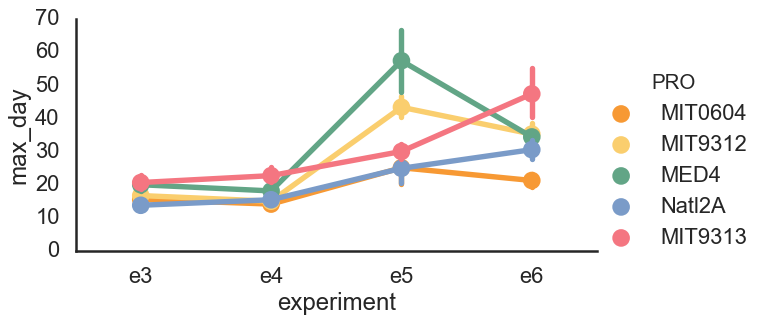

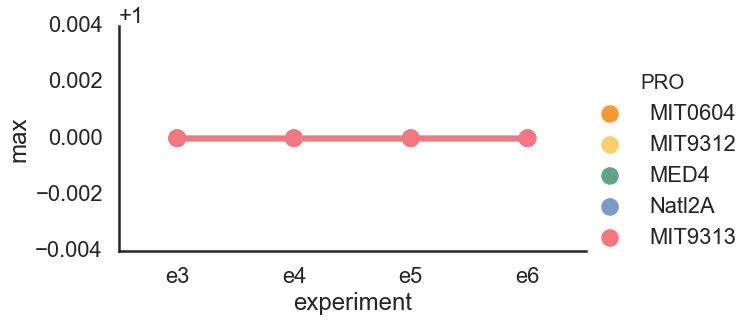

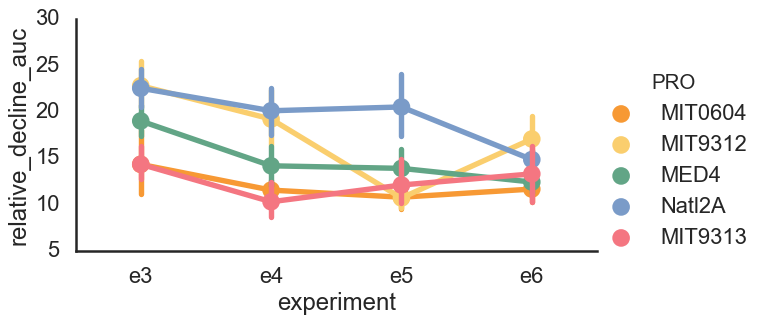

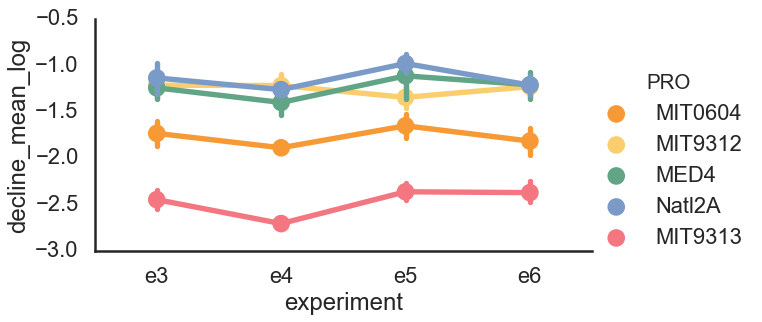

In [35]:
#X_features['experiment'] = metadf_features.experiment
sns.catplot(data=X_features_norm, y='max_day', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features_norm, y='max', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features_norm, y='relative_decline_auc', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features_norm, y='decline_mean_log', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
            aspect=1.8)


C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


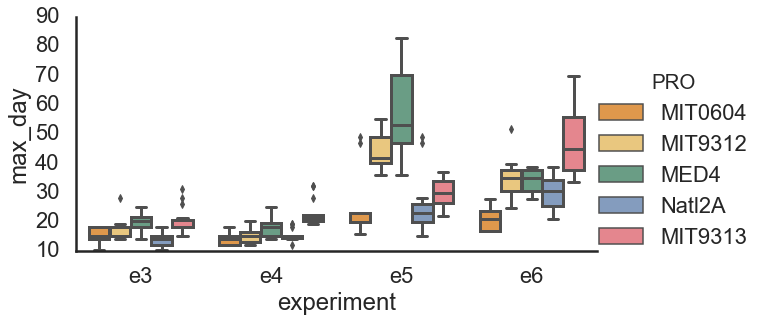

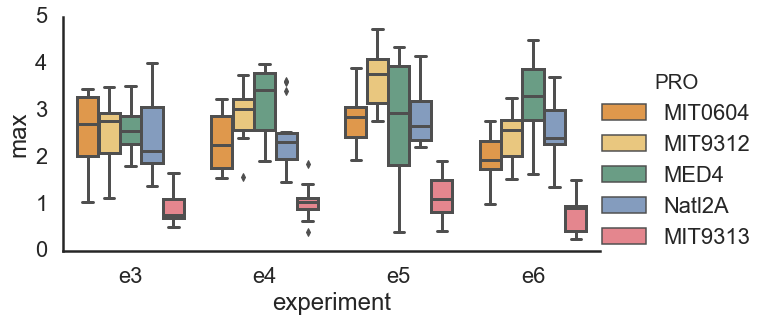

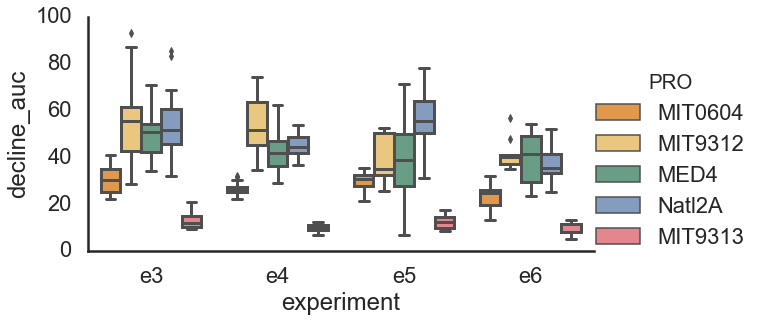

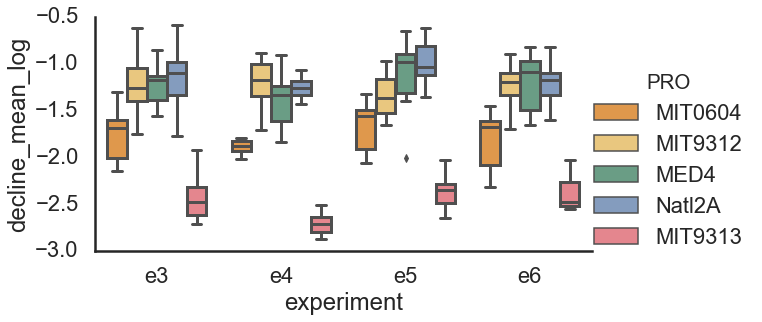

In [22]:
X_features['experiment'] = metadf_features.experiment
sns.catplot(data=X_features, y='max_day', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features, y='max', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features, y='decline_auc', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features, y='decline_mean_log', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)


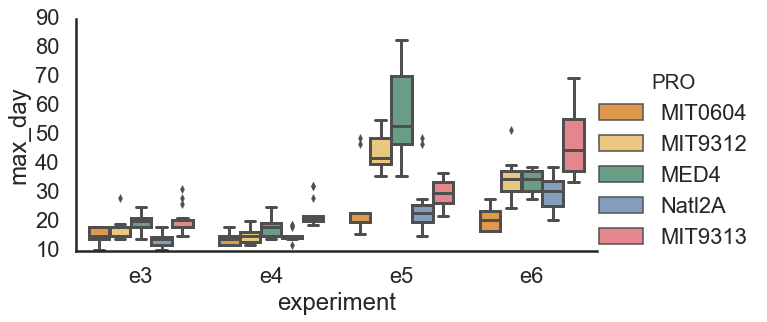

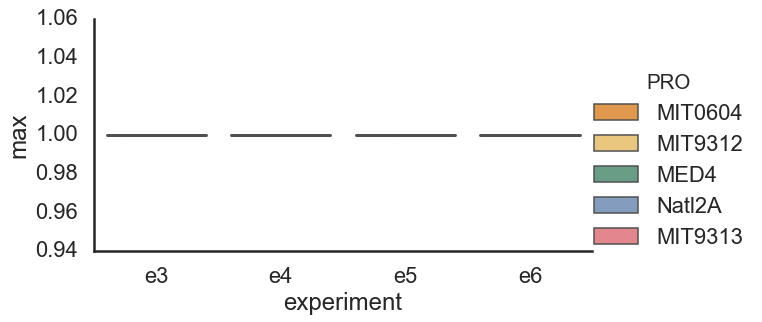

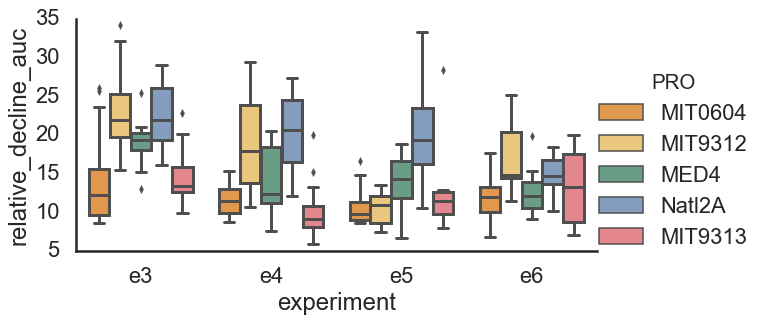

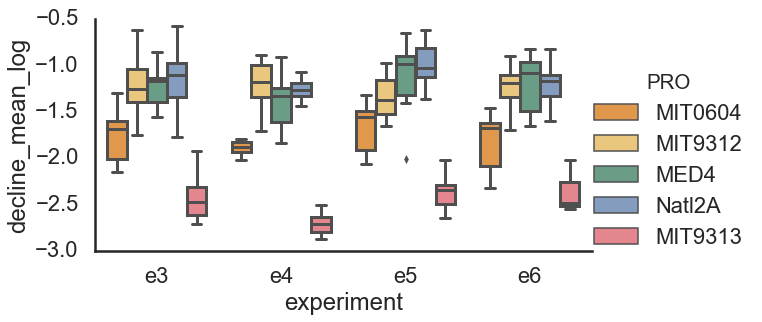

In [36]:
#X_features['experiment'] = metadf_features.experiment
sns.catplot(data=X_features_norm, y='max_day', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features_norm, y='max', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features_norm, y='relative_decline_auc', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)
sns.catplot(data=X_features_norm, y='decline_mean_log', x='experiment', hue='PRO', kind='box', hue_order=porder, palette=ppallete,
            aspect=1.8)


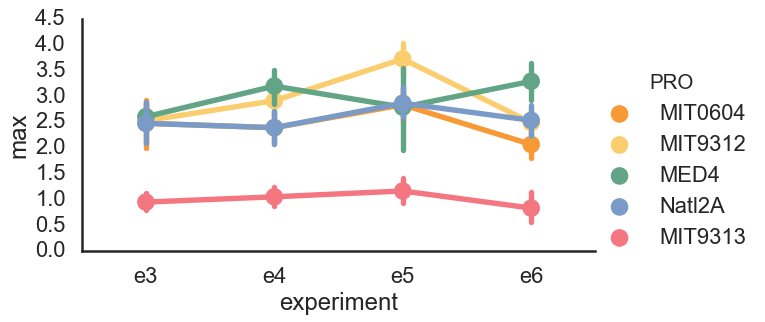

In [191]:
sns.catplot(data=X_features, y='max', x='experiment', hue='PRO', kind='point', hue_order=porder, palette=ppallete,
             aspect=1.8)
